In [19]:
from scipy.signal import filtfilt
from scipy.signal import butter,lfilter
from scipy.signal import freqs,freqz
import numpy as np
from scipy.fft import fft,ifft,fftfreq
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.signal import hilbert
from scipy import signal
%matplotlib inline
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import ipywidgets as widgets
from obspy.signal.trigger import recursive_sta_lta,carl_sta_trig,plot_trigger#,trigger_onset
from obspy.core.trace import Trace
from collections import deque 

In [2]:
def butter_bandpass(lowcut, highcut, fs, order=5):#band pass filter using butter worth method
    nyq = 0.5 * fs#nyquist frequency
    low = lowcut / nyq 
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')#parameters for filters/filter coefficients/coeff of digital transfer fn
    return b, a# coefficients of numerator and denomenator polynomial

In [3]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):#band pass filter using butter worth method
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)# coefficients of numerator and denomenator polynomial
    y = lfilter(b, a, data)#fir filter
    return y#filtered data

reading and processing data to make data easier to process

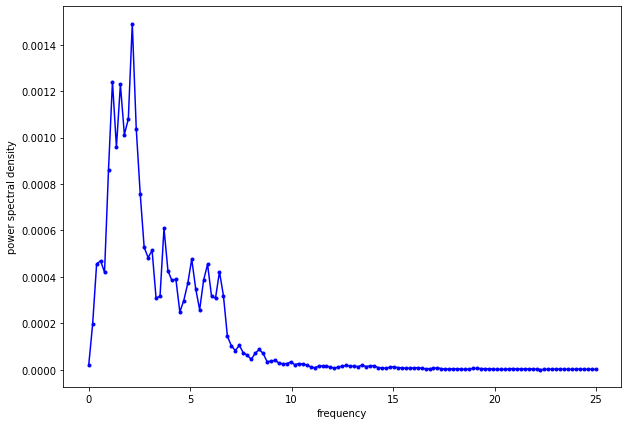

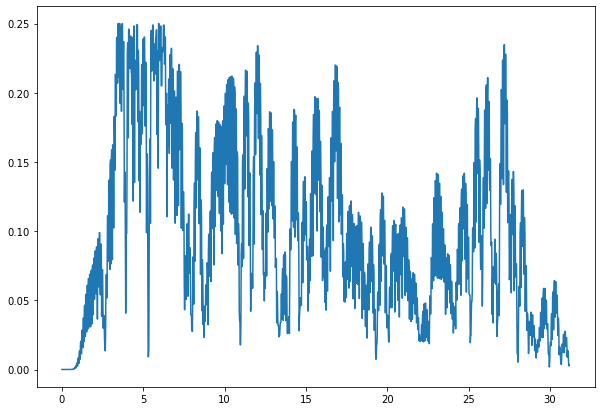

In [36]:
my_step=pd.read_csv('elcentro.csv')# reading data 
X=my_step['Acceleration']# accelerometer reading
plt.figure(figsize=(10,7))
freq,psd=signal.welch(X,50)# spectral density plot using welch method
plt.plot(freq,psd,'b.-')#plotting psd using welches method
plt.xlabel('frequency')
plt.ylabel('power spectral density')
#b, a = butter(10, 0.1, btype='low', analog=False)
y = butter_bandpass_filter(X,5,7,50,order=10)# band pass filter between 5 and 7 hrtz
y=abs(y)# to convert negative data from accelerometer to positive value 
y_max=np.max(y)# max value recorded by accelerometer
y_envelop=np.zeros_like(y)
y_envelop_2=np.zeros_like(y)
y_envelop[:]=(y[:]/y_max)-(y[:]/y_max)**2# a variable to almost map the original wave but with less ossciliations
for i in range(1,len(y)):
    y_envelop_2[0]=y_envelop[0]
    y_envelop_2[i]=np.max(y_envelop[i-1:i+1])#to reduce the osscilations even further and make the data more uniform 
y_hilbert=np.imag(hilbert(y_envelop_2))
plt.figure(figsize=(10,7))

plt.plot(my_step['Time'],y_envelop_2)

In [15]:
def trigger_onset(charfct, thres1, thres2, max_len=9e99, max_len_delete=False):   #to determine when the event is triggred and di triggered 
    ind1 = np.where(charfct > thres1)[0]# for points when magnitude is above thresh 1 
    if len(ind1) == 0:
        return []
    ind2 = np.where(charfct > thres2)[0]# for points when magnitude is above thresh 2
    on = deque([ind1[0]])# for points when magnitude is above thresh 1
    of = deque([-1])
    # determine the indices where charfct falls below off-threshold
    ind2_ = np.empty_like(ind2, dtype=bool)
    ind2_[:-1] = np.diff(ind2) > 1# to give true for points where trigger goes below thresh 2 after the magnitude increases above thresh 1 
    # last occurence is missed by the diff, add it manually
    ind2_[-1] = True
    of.extend(ind2[ind2_].tolist())# to create an array which stores point where the the event ends 
    on.extend(ind1[np.where(np.diff(ind1) > 1)[0] + 1].tolist()) # to create an array which stores the point where the event starts 
    # include last pick if trigger is on or drop it
    if max_len_delete:# in case max_len_delete is true
        # drop it
        of.extend([1e99])
        on.extend([on[-1]])
    else:
        # include it
        of.extend([ind2[-1]])
    #
    pick = []
    while on[-1] > of[0]: # some boundry conditions to avoid some conflicts 
        while on[0] <= of[0]:
             on.popleft()# for because in case the value of sta/lta is greater than thresh 1 from the get go and can provide false triggers
        while of[0] < on[0]:
             of.popleft() # to remove the cases where the value is greater than thr 2 but not than thr 1 to avoid false triggers
        if of[0] - on[0] > max_len:
            if max_len_delete:
                on.popleft()
                continue
            of.appendleft(on[0] + max_len)
        pick.append([on[0], of[0]])
    return np.array(pick, dtype=np.int64)

In [26]:
@widgets.interact(sta_time=(1,100,1),lta_time=(5,150,1),thr_on=(0.01,2,0.1),thr_off=(0.01,1,0.1))# just graphical representation of no importance
def alpha_calc(sta_time,lta_time,thr_on,thr_off):
    alpha=np.zeros(len(y))
    sta=0.
    csta=1./sta_time
    clta=1./lta_time
    icsta=1-csta
    iclta=1-clta
    lta=1e-99
    for i in range(1,len(y_envelop_2)):
       
      a=np.sqrt((y_envelop_2[i]**2)+(y_hilbert[i]**2))
      sta=a*csta+icsta*sta
      lta=a*clta+iclta*lta
      if(i<lta_time):
            alpha[i]=0
      else:
             alpha[i]=sta/lta
    plt.figure(figsize=(10,10))
    plt.plot(alpha)
    cft=alpha
    trace=Trace(np.array(y_envelop_2))
    df = trace.stats.sampling_rate
    npts = trace.stats.npts
    t = np.arange(npts, dtype=np.float32) / df
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(211)
    ax1.plot(t*0.02,y , 'k')
    ax2 = fig.add_subplot(212, sharex=ax1)
    ax2.plot(t*0.02, cft, 'k')
    cft1=np.array(cft)
    on_off = np.array(trigger_onset(cft1, thr_on, thr_off))
    i, j = ax1.get_ylim()
    try:
        ax1.vlines(on_off[:, 0]*0.02 / df, i, j, color='r', lw=2,
                   label="Trigger On")
        ax1.vlines(on_off[:, 1]*0.02 / df, i, j, color='b', lw=2,
                   label="Trigger Off")
        ax1.legend()
    except IndexError:
        pass
    ax2.axhline(thr_on, color='red', lw=1, ls='--')
    ax2.axhline(thr_off, color='blue', lw=1, ls='--')
    ax2.set_xlabel("Time after %s [s]" % trace.stats.starttime.isoformat())
    fig.suptitle(trace.id)
    fig.canvas.draw()
    plt.show()

interactive(children=(IntSlider(value=50, description='sta_time', min=1), IntSlider(value=77, description='lta…